In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import geopandas
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import graphing
import src.graphing
pd.set_option('display.max_columns',None)

## Import Data

In [ ]:
distpath ='../data/shapefiles/tanzania_districts/Districts.shx'
featurepath = "../data/training_set_values.csv"
label_path = "../data/training_set_labels.csv"
poppath = '../data/tanzania_district_pop.csv'
districts = geopandas.read_file(distpath)
features = pd.read_csv(featurepath)
label = pd.read_csv(label_path)
tpop = pd.read_csv(poppath)

## Prepare dataframes

In [ ]:
tpop = tpop[['ADM2_EN','TOTAL_BOTH']]

df = pd.merge(features,label, on = 'id')
df = df.rename(columns={'status_group':'target'})
df.loc[df['longitude'] == 0, 'longitude'] = np.nan

district_nums = df.groupby('lga').count()

df_geo = pd.merge(district_nums,districts, how = 'right', 
                  left_on = 'lga', right_on='District_N')
df_geo = pd.merge(df_geo,tpop, how = 'left', right_on = 'ADM2_EN', 
                  left_on = 'District_N')
df_geo = geopandas.GeoDataFrame(df_geo)
df_geo['log_pop'] = np.log(df_geo['TOTAL_BOTH'])

wells_func = wells[wells['target'] == 'functional']
wells_nonfunc = wells[wells['target'] == 'non functional']
wells_repair = wells[wells['target'] == 'functional needs repair']
wells = geopandas.GeoDataFrame(df[['latitude','longitude','target']],
                               geometry = geopandas.points_from_xy(df.longitude, df.latitude))
wells = wells.set_crs(epsg = 4210)

## Map population and well locations

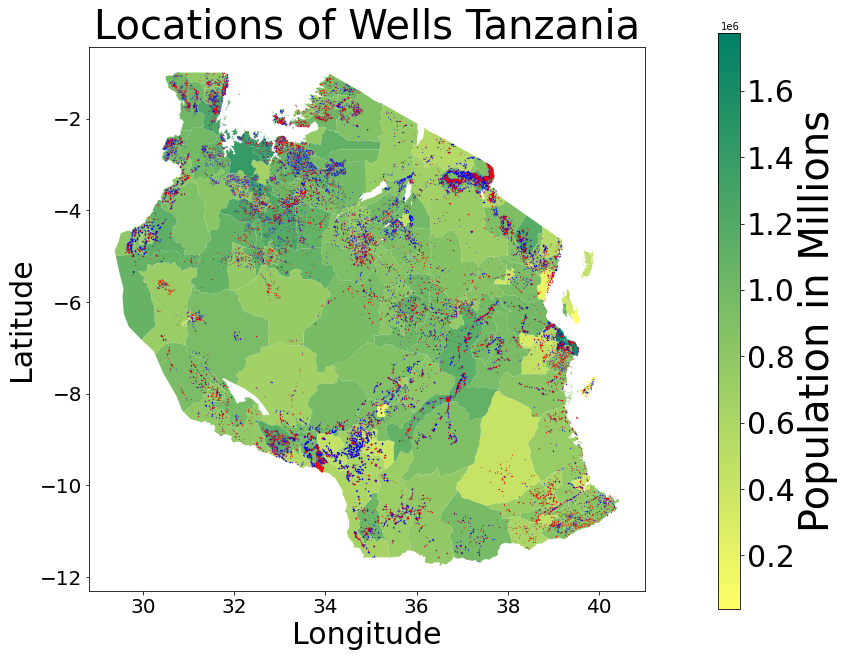

In [20]:
fig, ax = plt.subplots(figsize = (10,10))
cmap='summer_r'

df_geo.plot(ax = ax,
           column = 'log_pop',
           legend = False,
           cmap = cmap,
           #missing_kwds = {'color':'lightgrey'} #Breaks the map if no NaNs
           )

ax.set_title('Locations of Wells Tanzania', fontsize = 40, y=.8)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax.set_ylabel('Latitude',  fontsize = 30)
ax.set_xlabel('Longitude', fontsize = 30)
vmin = df_geo['TOTAL_BOTH'].min()
vmax = df_geo['TOTAL_BOTH'].max()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=30) 
cbr.set_label('Population in Millions', fontsize = 40)
wells_func.plot(ax = ax, color = 'blue', markersize = .01)
wells_repair.plot(ax = ax, color = 'blue', markersize = .01)
wells_nonfunc.plot(ax = ax, color = 'red', markersize = .01)
plt.savefig('figures/well_loc_and_pop_tanzania',bbox_inches = 'tight')
plt.show()